# GAN

In this TP we are interested in generating images from the MNIST dataset usy traditionnal GAN

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.
//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


Load the MNIST dataset

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Rescale -1 to 1
X_train = x_train / 127.5 - 1.
X_train = np.expand_dims(x_train, axis=3)

In [4]:
X_train.shape

(60000, 28, 28, 1)

In [5]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

##### 1. Create a generator model
The generator has the following layers :
    - A dense layer of width 256 and take as input the dimension of the latent space (this is a paremeter that must be configurable
    - A LeakyRelu activation with parameter alpha=0.2 : what does it correspond to ?
    - We use batch normalization of momentum 0.8 : what does it correspond to ?
    
    - A second dense layer of width 512
    - We use same LeakyRelu and batch normalization for this layer
    
    - A third Dense Layer of width 1024 with same batch normalization and LeakyRelu activation
    
    - A last dense layer with width equal to the shape of the output image flattened
    - The activation is tanh : what does is correspond to ?
    
    The function must take as input a vector of dimension the dimension of the latent space and representing the noise and return Model

In [6]:
def build_generator(img_shape,latent_dim=100):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

##### 2. Build the discriminator
The discriminator has the following layers :
    - A Dense layer of width 512 with LeakyRelu activation with parameter alpha=0.2
    - A second Dense layer with LeakyRelu activation with parameter alpha=0.2
    - A last Dense layer for the binary classification 
    
    The model must take as input an image and output the the classification result

In [7]:
def build_discriminator(img_shape):

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

##### 3. Build the two neural networks with the MNIST configuration and print their properties. We will use a dimension of the latent space equa to 100

In [9]:
latent_dim=100

In [10]:
generator=build_generator(img_shape,latent_dim=latent_dim)

In [11]:
generator.get_layer('sequential_1').summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
__________

In [12]:
discriminator=build_discriminator(img_shape)

In [15]:
discriminator.get_layer('sequential_2').summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


##### 4. Compile the model

The optimizer chosen is 'Adam' with parameters 0.0002 and 0.5 : what does it correspond to ?

First compile the discriminator

In [16]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

To compile the generator it is more tricky :

In [17]:
# The generator takes noise as input and generates imgs
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Live explanations

##### 5. Write a function that sample 25 images from a normal noise $\mathcal{N}(0,I_{d})$ with d configurable. It should be configurable wether we save or plot the images

In [18]:
def sample_images(generator,latent_dim=100,toplot=False,epoch=None):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c,figsize=(10,10))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    if toplot:
        plt.show()
    else:
        fig.savefig("images/%d.png" % epoch)
    plt.close()

##### 6. Train the model using batch_size of 32 and 10000 epochs

In [21]:
batch_size=32
epochs=10000

In [22]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
dloss_onreal=[]
dloss_onfake=[]
total_dloss=[]
gloss=[]
for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate a batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Train the generator (to have the discriminator label samples as valid)
    g_loss = combined.train_on_batch(noise, valid)
    
    
    dloss_onreal.append(d_loss_real)
    dloss_onfake.append(d_loss_real)
    total_dloss.append(d_loss)
    gloss.append(g_loss)
    
    if epoch % 100 ==0:
        print('epoch number : ',str(epoch))
        sample_images(generator,epoch=epoch)

//anaconda/lib/python3.5/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch number :  0
epoch number :  100
epoch number :  200
epoch number :  300
epoch number :  400
epoch number :  500
epoch number :  600
epoch number :  700
epoch number :  800
epoch number :  900
epoch number :  1000
epoch number :  1100
epoch number :  1200
epoch number :  1300
epoch number :  1400
epoch number :  1500
epoch number :  1600
epoch number :  1700
epoch number :  1800
epoch number :  1900
epoch number :  2000
epoch number :  2100
epoch number :  2200
epoch number :  2300
epoch number :  2400
epoch number :  2500
epoch number :  2600
epoch number :  2700
epoch number :  2800
epoch number :  2900
epoch number :  3000
epoch number :  3100
epoch number :  3200
epoch number :  3300
epoch number :  3400
epoch number :  3500
epoch number :  3600
epoch number :  3700
epoch number :  3800
epoch number :  3900
epoch number :  4000
epoch number :  4100
epoch number :  4200
epoch number :  4300
epoch number :  4400
epoch number :  4500
epoch number :  4600
epoch number :  4700
epoc

##### 6. Sample 25 generated images and plot the loss curves

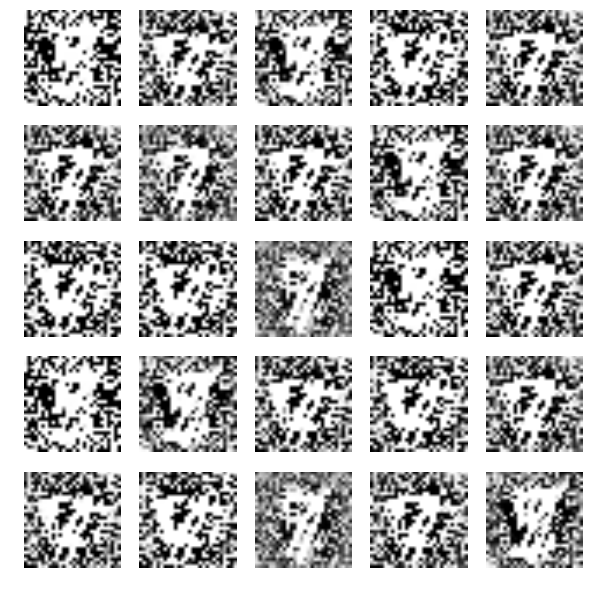

In [23]:
sample_images(generator,toplot=True)

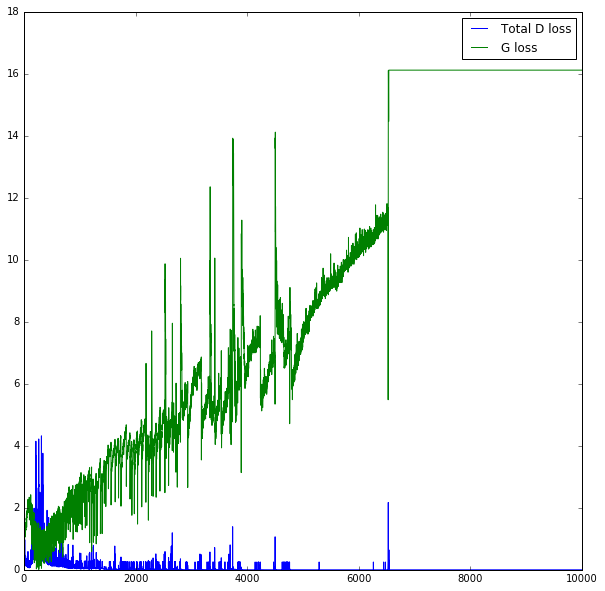

In [50]:
plt.figure(figsize=(10,10))
plt.plot(np.array(total_dloss)[:,0])
plt.plot(gloss)
plt.legend(['Total D loss','G loss'])
plt.show()

# DCGAN : Live demonstration using GPU